## Training - Guideline

This notebook was designed with the purpose of guiding you with the development of your first Training Job

There are many functions and methods that we provide you in the melitk.analytics library (which comes pre-installed), but will not appear in this demo. The general idea behind this demo is for you to understand how the Fury Data Apps expects your Training process in order to run successfully and generate the model (and eventually metrics) you expect

### Example

Here we will read the dataset that we generated in the demo etl/etl.ipynb and train a Sklearn Decission Tree model to predict the probability of some users of recharging their cellphones

## Imports

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np
import datetime
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
import dask.dataframe as dd
from dask.multiprocessing import get
from collections import Counter
from sklearn.model_selection import train_test_split
import gc
import joblib
import boto3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
config = tf.ConfigProto(device_count={"CPU": 20})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from keras.callbacks import EarlyStopping
import joblib
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import load_model
from utils import _write_dataframe_to_csv_on_s3,asigno_quintiles_6, print_s3,f1 
debug = True

Using TensorFlow backend.


## Initial Setup

## Reading the dataset

Load the dataset (that was saved in the ETL script) and split it into train and test sets.

In [2]:
print_s3("----------------------------------------------------------'",
         "s3://fda-labs/ltv-ml/Dense/log.txt")

print_s3("Starting'","s3://fda-labs/ltv-ml/Dense/log.txt")

if(debug == False):
    n_jobs_ramdomized = 20
    n_iter = 30
else:
    n_jobs_ramdomized = 5
    n_iter = 2

----------------------------------------------------------'
Starting'


In [3]:
if(debug == False):
    summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/preproc_data_train.csv.gzip')  # Because in the ETL we pickled the pandas dataframe
else:
    summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv')  # Because in the ETL we pickled the pandas dataframe

In [4]:
if(debug == False):
    train = summary_cal.sample(frac = 1.,random_state=20)
else:
    train = summary_cal.sample(frac = 0.025,random_state=20)

In [6]:
train_cols = [ 'frequency', 'recency', 'T', 'monetary_value', 'my_recency', 'n_purchases_pred', 'p_alive',
                       'montary_sales_forecast', 'clv_pareto', 'target_pareto','IPT_CV', 'money_sum',
                       'money_CV', 'money_mean', 'money_std', 'money_max', 'money_min',
                       'L1_1000', 'L1_1039', 'L1_1051', 'L1_1071', 'L1_1132', 'L1_1144',
                       'L1_1168', 'L1_1182', 'L1_1246', 'L1_1276', 'L1_1367', 'L1_1368',
                       'L1_1384', 'L1_1403', 'L1_1430', 'L1_1499', 'L1_1574', 'L1_1648',
                       'L1_1798', 'L1_1953', 'L1_2547', 'L1_3025', 'L1_3937', 'L1_407134',
                       'L1_409431', 'L1_5725', 'L1_5726', 'female', 'male', 'Account Money',
                       'Bank Transfer', 'Credit Card', 'Debit Card', 'Ticket',
                       'digital_currency', '01.Menor de 18 años', '02.Entre 18 y 25 años',
                       '03.Entre 26 y 30 años', '04.Entre 31 y 35 años',
                       '05.Entre 36 y 40 años', '06.Entre 41 y 55 años',
                       '07.Entre 56 y 65 años', '08.Mayor de 65 años']

In [6]:
X_train = train[train_cols]
Y_train = train.quintil_true

print_s3("Cargo Dataset'","s3://fda-labs/ltv-ml/Dense/log.txt")

stdc = StandardScaler()
stdc_trained = stdc.fit(X_train)
X_train = stdc_trained.transform(X_train)

Cargo Dataset'


In [7]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)
y_train = np_utils.to_categorical(encoded_Y)

In [8]:
def create_model(input_shape,nl=1,nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,batch=1, output_shape=6):
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture'''

    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()

    for i,n in zip(list(range(nl)),[nn1,nn2,nn3]):   
        model.add(Dense(n, input_dim=input_shape, activation=act, kernel_regularizer=reg))

        if dropout!=0:
            model.add(Dropout(dropout))
            
        if batch == 1:
            model.add(BatchNormalization())
        
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[f1])
    return model


In [9]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.01, 
                     patience=10, 
                   verbose=1, 
                   restore_best_weights=True)
    
model = KerasClassifier(build_fn=create_model, batch_size=128, epochs=50,
                            verbose=2)

In [10]:
# learning algorithm parameters
lr=[1e-2, 1e-3, 1e-4]
decay=[1e-6,1e-9,0]

# activation
activation=['relu', 'sigmoid']

# numbers of layers
nl = [1,2,3]

# neurons in each layer
nn1=[32,50,100, 200,300,400]
nn2=[15,30,50,100,200]
nn3=[15,30,50]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3,0.5]
batch = [0,1]
l1 = [0, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.01, 0.003, 0.001,0.0001]

# dictionary summary
param_grid = dict(
                    nl=nl, nn1=nn1, nn2=nn2, nn3=nn3,
                    act=activation, l1=l1, l2=l2, lr=lr, decay=decay, dropout=dropout,batch = batch,
                    input_shape = [X_train.shape[1]]
                  
                 )
print("Cantidad de parametros:",sum([len(x) for x in param_grid.values() if(type(x) != int)]))

Cantidad de parametros: 43


In [11]:
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train), Y_train)

grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=param_grid,
                          verbose=20,  n_iter=n_iter, n_jobs=n_jobs_ramdomized,scoring = "f1_weighted")

print_s3("Aarrancando a entrenar'","s3://fda-labs/ltv-ml/Dense/log.txt")
grid.fit(X_train,Y_train,class_weight = weights, validation_split = 0.2,callbacks=[es],verbose=10)

Aarrancando a entrenar'
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done   2 out of   6 | elapsed:    7.9s remaining:   15.8s
[Parallel(n_jobs=5)]: Done   3 out of   6 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=5)]: Done   4 out of   6 | elapsed:   10.0s remaining:    5.0s


Instructions for updating:
Colocations handled automatically by placer.


[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:   12.1s finished


Instructions for updating:
Use tf.cast instead.
Train on 5109 samples, validate on 1278 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5dfcc10fd0>,
                   iid='warn', n_iter=2, n_jobs=5,
                   param_distributions={'act': ['relu', 'sigmoid'],
                                        'batch': [0, 1],
                                        'decay': [1e-06, 1e-09, 0],
                                        'dropout': [0, 0.1, 0.2, 0.3, 0.5],
                                        'input_shape': [60],
                                        'l1': [0, 0.01, 0.003, 0.001, 0.0001],
                                        'l2': [0, 0.01, 0.003, 0.001, 0.0001],
                                        'lr': [0.01, 0.001, 0.0001],
                                        'nl': [1, 2, 3],
                                        'nn1': [32, 50, 100, 200, 300, 400],
                              

In [12]:
print_s3("Seleccione los mejores hiperparametros'","s3://fda-labs/ltv-ml/Dense/log.txt")

params = grid.best_params_

## create the model with the best params found
model = create_model(**params)


## Then train it and display the results
model_hist = model.fit(X_train,
                    y_train,
                    class_weight = weights, validation_split = 0.2,callbacks=[es],batch_size=128, epochs=50,verbose=10)


Seleccione los mejores hiperparametros'
Train on 5109 samples, validate on 1278 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


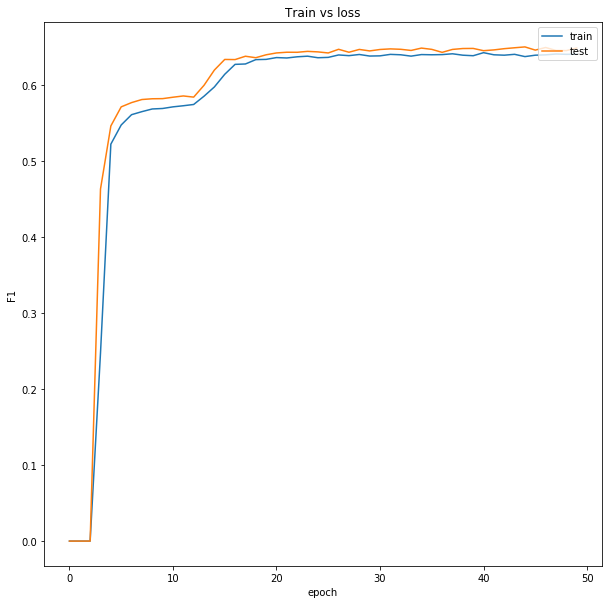

In [13]:
plt.figure(figsize = (10,10))
plt.plot(model_hist.history['f1'])
plt.plot(model_hist.history['val_f1'])
plt.title('Train vs loss')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("ModelPerformance.png")

s3 = boto3.client('s3')
s3.upload_file("ModelPerformance.png", "fda-labs", "ltv-ml/Dense/ModelPerformance.png")

In [14]:
_write_dataframe_to_csv_on_s3(pd.DataFrame(grid.cv_results_),"s3://fda-labs/ltv-ml/Dense/ModelPerformance.csv")

In [15]:
model.save("model.h5")
joblib.dump(stdc_trained,"std.sav")

s3 = boto3.client('s3')
s3.upload_file("model.h5", "fda-labs", "ltv-ml/Dense/model.h5")
s3.upload_file("std.sav", "fda-labs", "ltv-ml/Dense/std.sav")

print_s3("Modelo Creado","s3://fda-labs/ltv-ml/Dense/log.txt")

Modelo Creado


## Saving some model metrics

Although you might be able to get your trained model without metrics, generating these metrics will allow to compare trained models and their performance from the Train front-end in your Fury Data App. We strongly encourage you to store some key metrics to measure your model's performance correctly, as it gives you an idea of how will your model performe with more realistic data

In [4]:
summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/preproc_data_test.csv.gzip') 
print_s3("Levante data de testing","s3://fda-labs/ltv-ml/Dense/log.txt")

Levante data de testing


In [7]:
s3 = boto3.client('s3')
s3.download_file("fda-labs", "ltv-ml/Dense/std.sav","std.sav")
stdc_trained = joblib.load("std.sav")
s3.download_file("fda-labs", "ltv-ml/Dense/model.h5","model.h5")

dependencies = {
    'f1': f1
}

model = load_model("model.h5",custom_objects=dependencies)

encoder = LabelEncoder()
encoder.fit(summary_cal.quintil_true)


X = stdc_trained.transform(summary_cal[train_cols]) 
y = np_utils.to_categorical(encoder.transform(summary_cal.quintil_true))

In [8]:
y_pred = model.predict(X)
summary_cal[["q1","q2","q3","q4","q5","q6"]] = pd.DataFrame(y_pred)


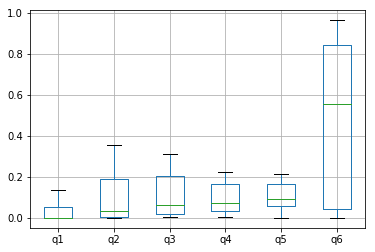

In [9]:
apply_me = summary_cal
apply_me[["q1","q2","q3","q4","q5","q6"]].boxplot(showfliers = False)

In [10]:
def asigno_quintiles_1(x,step,q):    
    step2 = x.shape[0] - (step)
    l_ = ["q"+q]*step + ["non_q"]*step2
    return l_ 

apply_me["pred_q"] = "non_q"
resu = pd.DataFrame([])
step1 = int(apply_me.shape[0]*0.1)
step2 = int(apply_me.shape[0]*0.5)

for i in range(4):
    df = apply_me.loc[apply_me.pred_q == "non_q"]
    df = df.sort_values(by = "q"+str(i+1),ascending = False)
    df["pred_q"] = asigno_quintiles_1(df,step1,str(i+1))
    df = df.loc[df.pred_q != "non_q"]
    apply_me.loc[apply_me.cust.isin(df.cust.values),"pred_q"] = "q"+str(i+1)

df = apply_me.loc[apply_me.pred_q == "non_q"]
df = df.sort_values(by = "q6",ascending = False)
df["pred_q"] = asigno_quintiles_1(df,step2,"6")
df = df.loc[df.pred_q != "non_q"]
apply_me.loc[apply_me.cust.isin(df.cust.values),"pred_q"] = "q6"

apply_me.loc[apply_me.pred_q == "non_q","pred_q"] = "q5"

apply_me = apply_me.sort_values(by = "target_pareto",ascending = False)
apply_me["pareto_q"] = asigno_quintiles_6(apply_me)

In [11]:
l_ = []
for i in range(6):
    aux = apply_me.loc[apply_me["quintil_true"] == "q"+str(i+1)]
    aux2 = aux.loc[aux["pred_q"] == "q"+str(i+1)]
    l_.append({"q":"q"+str(i+1), "recall": aux2.shape[0]/aux.shape[0]})
    
_write_dataframe_to_csv_on_s3(pd.DataFrame(l_),"s3://fda-labs/ltv-ml/Dense/final_performance.csv")

In [12]:
confusion = confusion_matrix(apply_me["quintil_true"],apply_me["pred_q"])
for i in range(confusion.shape[0]):
    confusion[i,:] = 100*confusion[i,:]/confusion.sum(axis = 1)[i]

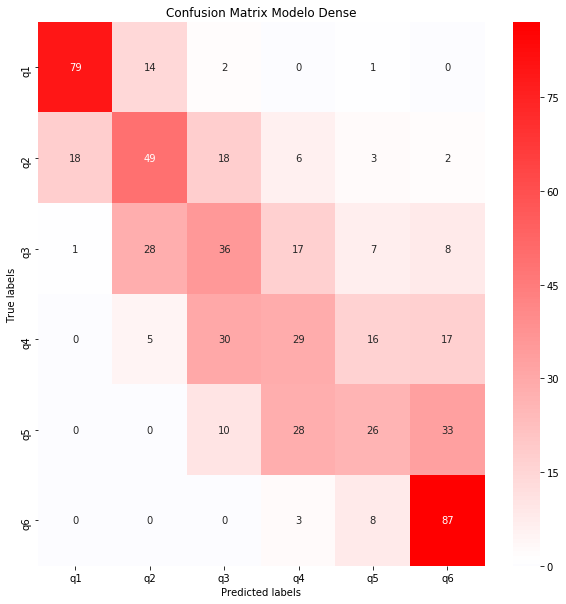

In [13]:
labels = ['q1', 'q2','q3','q4','q5','q6']
plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(confusion,annot = True,center = 1,ax=ax,cmap='bwr')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Modelo Dense'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

plt.savefig("confusion_matrix.png")

s3 = boto3.client('s3')
s3.upload_file("confusion_matrix.png", "fda-labs", "ltv-ml/Dense/confusion_matrix.png")